In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I have 40 variables and a fraction of 40% of the majority data. Therefore, I want to use ***Principal Component Analysis (PCA)*** to input less variables into the random forest model. PCA is a dimensionality reduction technique that projects the original features into a lower-dimensional space, capturing the most important information.

This script took a very long time so I did not get the result.

However, PCA makes the inputs less interpretable. ***It involves information loss since it retains only a subset of the original features.*** Random Forest can inherently handle non-linear relationships in the data. PCA might not provide significant benefits in such cases.

I tried this method anyway because I would like to see the effect, but it should not hurt much if I could not finish funning it.

## Load data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Redback_B/Heart_2022/heart_2022_no_nans.csv')

In [ ]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into majority class ('No') and minority class ('Yes')
df_majority = df[df['HadHeartAttack'] == 'No']
df_minority = df[df['HadHeartAttack'] == 'Yes']

fraction_to_keep = 0.4

# Randomly sample a portion
df_majority_sampled = df_majority.sample(frac=fraction_to_keep, random_state=42)

# Combine the two to make a balanced dataset
df_balanced = pd.concat([df_minority, df_majority_sampled])

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df = df_balanced.copy()

## Model Data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

# Define X and y
y = df.HadHeartAttack
X = df.drop('HadHeartAttack', axis=1)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=456)

In [ ]:
# Convert target variable into numbers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_data(X_train, X_test):
    # Separate numerical and categorical columns
    numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    # Normalize numerical data using StandardScaler
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Apply LabelEncoder to categorical data
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        X_train[column] = label_encoder.fit_transform(X_train[column])
        X_test[column] = label_encoder.transform(X_test[column])

    return X_train, X_test

X_train_processed, X_test_processed = preprocess_data(X_train.copy(), X_test.copy())

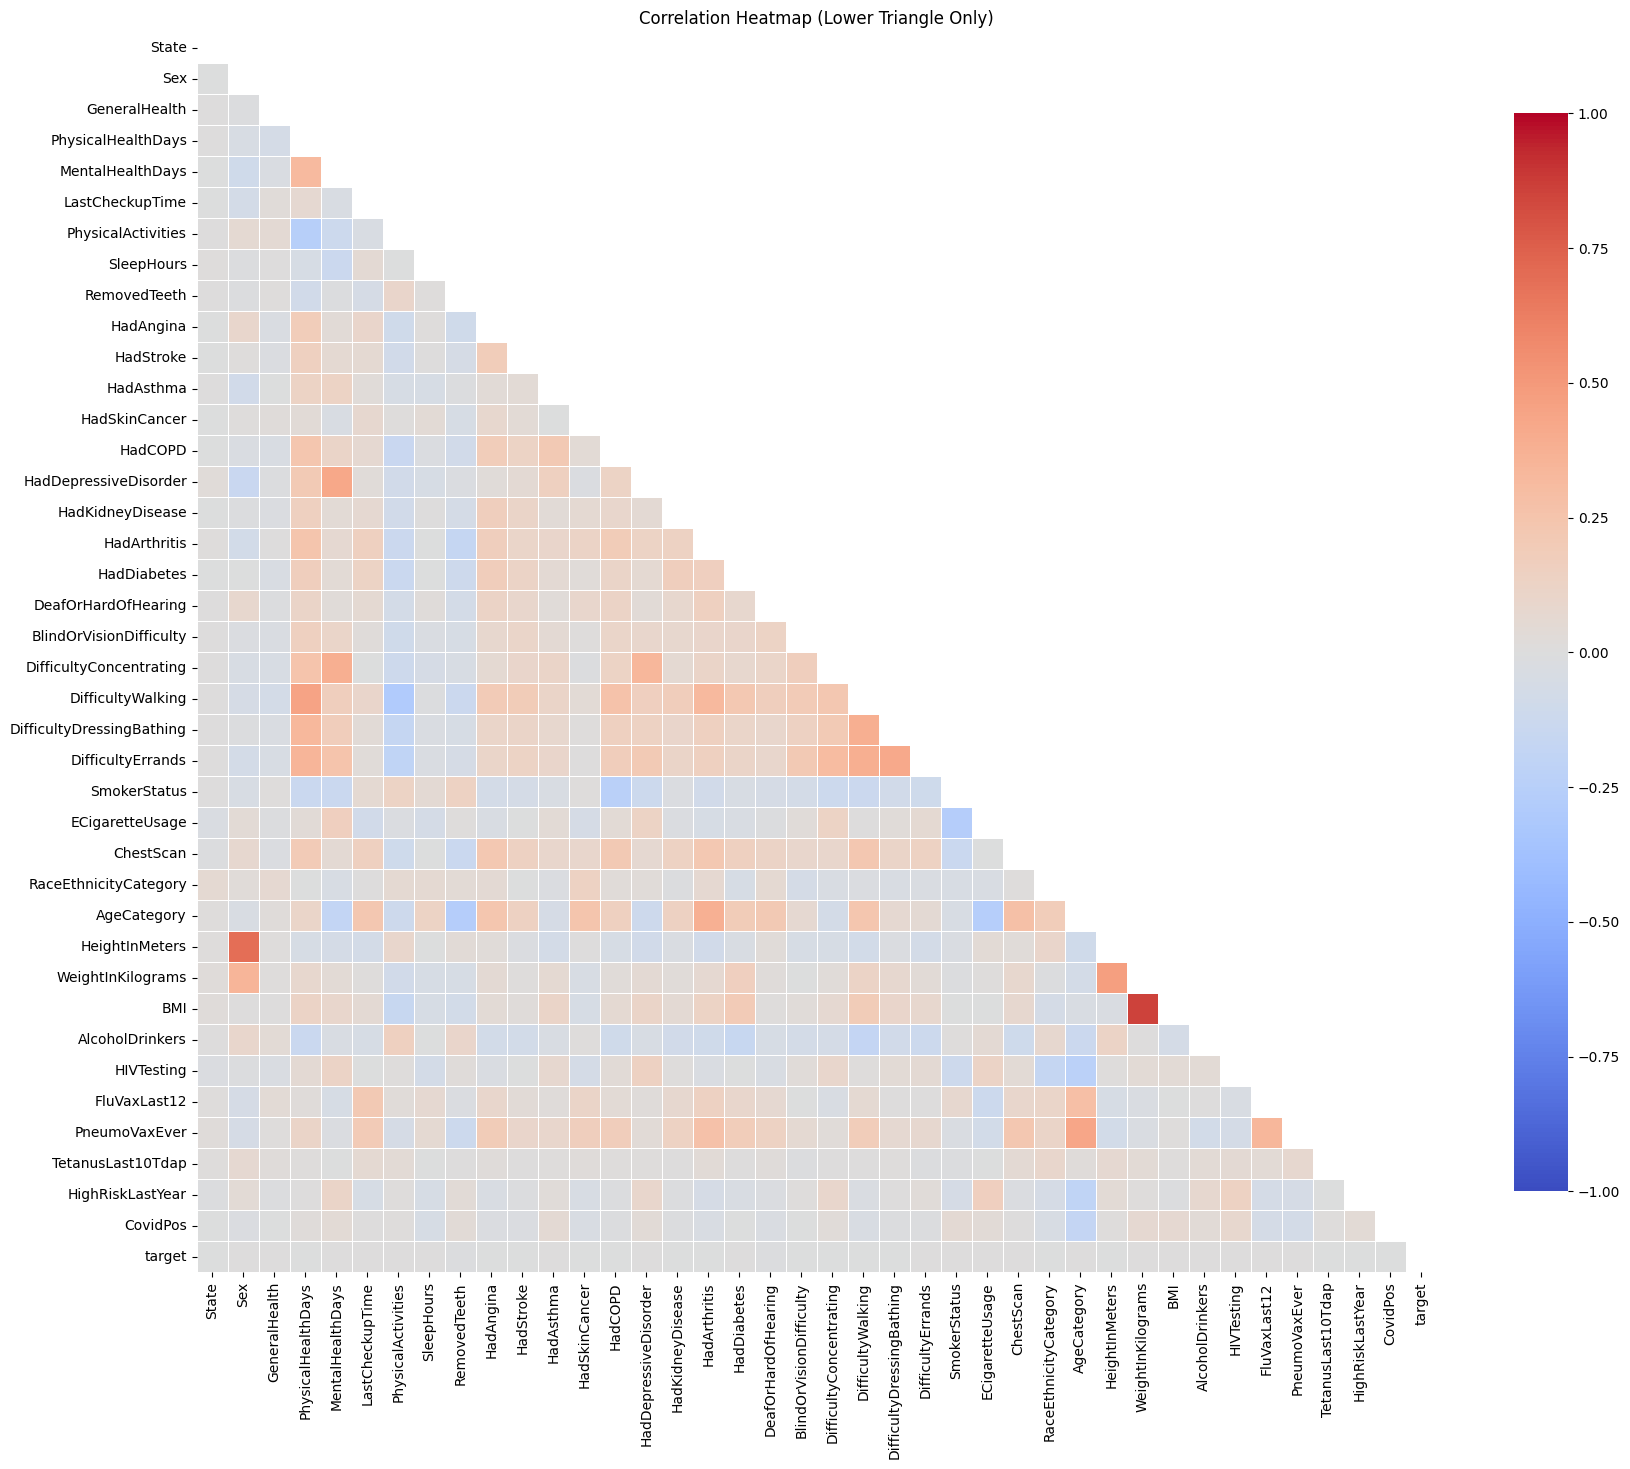

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = pd.concat([X_train_processed, pd.Series(y_train, name='target')], axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", mask=mask,
            cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

plt.title('Correlation Heatmap (Lower Triangle Only)')
plt.show()

In [ ]:
import time

# Start the timer
start_time = time.time()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with PCA and Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA()),
    ('rf', RandomForestClassifier())
])

# Set the parameter grid to search over
param_grid = {
    'pca__n_components': [5, 10, 20],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10, None],
    'rf__max_features': ['sqrt', 'log2']
}

# Use GridSearchCV to search over the parameter grid and find the best parameter values
grid_search = GridSearchCV(rf_pipeline, param_grid=param_grid, cv=3)
grid_search.fit(X_train_processed, y_train)

# Print the best parameter values
print("Best parameters: ", grid_search.best_params_)

# Access the best RF model from the pipeline
best_rf_model = grid_search.best_estimator_.named_steps['rf']

# Perform cross-validation on the training set
cv_scores_rf = cross_val_score(grid_search.best_estimator_, X_train_processed, y_train, cv=3)

# Print the cross-validation scores
print("Parameter values of best_rf: ", best_rf_model.get_params())
print("Cross-validation scores for Random Forest:", cv_scores_rf)

Best parameters:  {'pca__n_components': 20, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Parameter values of best_rf:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Cross-validation scores for Random Forest: [0.88906332 0.89135773 0.89300809]


In [ ]:
# fit the model on the training set
random_forest = best_rf_model.fit(X_train_processed, y_train)

# Predict the labels
y_predicted = random_forest.predict(X_test_processed)

# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on the test set:  0.9076109076109076
[[0.84765662 0.02614195]
 [0.06624714 0.05995429]]


In [ ]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 3445.06 seconds


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Precision
precision = precision_score(y_test, y_predicted)

# Recall
recall = recall_score(y_test, y_predicted)

# F1 Score
f1 = f1_score(y_test, y_predicted)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6964
Recall: 0.4751
F1 Score: 0.5648


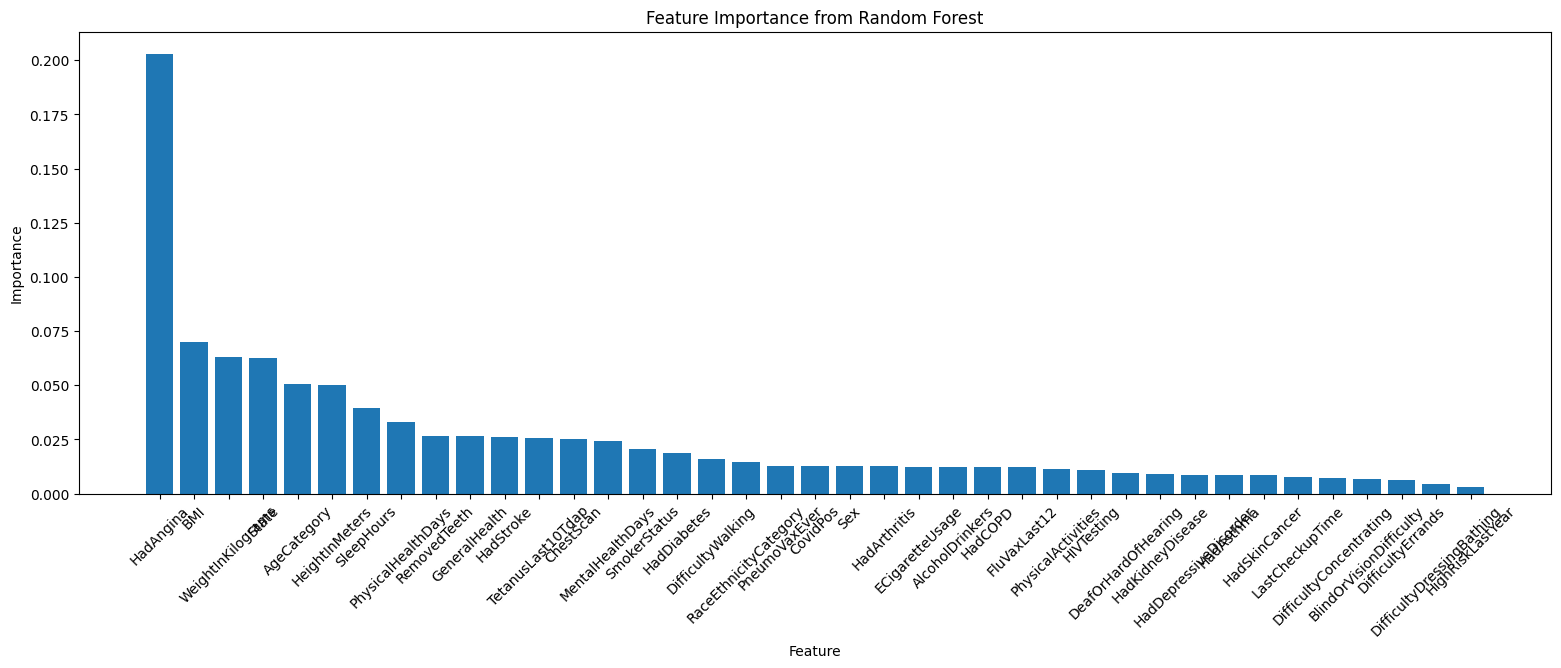

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Sort features in descending order of importance
import numpy as np
indices = np.argsort(feature_importances)[::-1]

# Get the feature names
feature_names = X_train_processed.columns

# Plot the feature importances
plt.figure(figsize=(19, 6))
plt.bar(range(X_train_processed.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_processed.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()